In [1]:
import os

from typing import Type, Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import torch
import pyro

import torch

from torch.utils.data import DataLoader

import pyro

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data
from pyro.infer import Predictive

import contextlib


smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [50]:
zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))


AttributeError: 'ZoningDataset' object has no attribute 'keys'

In [3]:

def replace_categorical_with_combos(data: Dict, interaction_tuples: List[Tuple[str,...]], 
                                    kwarg_names: Dict[str, List[str]]):

    if kwarg_names:
        data_copy = select_from_data(data.copy(), kwarg_names)

    unique_combined_tensors = {}
    inverse_indices_tensors = {}
    indexing_dictionaries = {}

    for interaction_tuple in interaction_tuples:

        assert len(interaction_tuple) > 1

        tensors_to_stack = [data_copy['categorical'][key] for key in interaction_tuple]

        for tensor in tensors_to_stack:
            assert tensor.shape == tensors_to_stack[0].shape
    
        stacked_tensor = torch.stack(tensors_to_stack, dim=-1)
        
        unique_pairs, inverse_indices = torch.unique(stacked_tensor, 
                                            return_inverse=True, dim=0)

        inverse_indices_tensors[interaction_tuple] = inverse_indices

        unique_combined_tensor = inverse_indices.reshape(
            data_copy['categorical'][interaction_tuple[0]].shape)

        unique_combined_tensors[interaction_tuple] = unique_combined_tensor

        indexing_dictionaries[interaction_tuple] = {tuple(pair.tolist()): i for i, pair in enumerate(unique_pairs)}

        data_copy['categorical'][f"{'_'.join(interaction_tuple)}"] = unique_combined_tensor

        for key in interaction_tuple:
            data_copy['categorical'].pop(key, None)



    return data_copy, indexing_dictionaries


In [4]:
def add_categorical_interactions(model_class: Type, data, interaction_tuples: List[Tuple[str,...]],
                                kwarg_names: Optional[Dict[str, List[str]]]):
    
    new_data = data.copy()

    new_data, indexing_dictionaries = replace_categorical_with_combos(new_data, interaction_tuples, kwarg_names)
    
    model = model_class(**new_data)

    return model, new_data, indexing_dictionaries


kwarg_names = {
    "categorical": ["zone_id", "past_reform"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}


new_model, new_data, indexing_dictionaries = add_categorical_interactions(SimpleLinear, 
                                        data = data,
                                        interaction_tuples= [("zone_id", "past_reform")],
                                         kwarg_names =  kwarg_names)


#TODO add potential interactions to evaluation

[iteration 0001] loss: 1193.0200
[iteration 0050] loss: 495.3089
[iteration 0100] loss: 413.0825
[iteration 0150] loss: 401.2442
[iteration 0200] loss: 389.8350
[iteration 0250] loss: 395.2184
[iteration 0300] loss: 396.7337
[iteration 0350] loss: 392.7579
[iteration 0400] loss: 391.2100
[iteration 0450] loss: 391.4405
[iteration 0500] loss: 400.1179
[iteration 0550] loss: 389.9820
[iteration 0600] loss: 389.7437
[iteration 0650] loss: 390.6473
[iteration 0700] loss: 390.0622
[iteration 0750] loss: 391.0051
[iteration 0800] loss: 392.3842
[iteration 0850] loss: 389.8912
[iteration 0900] loss: 390.9186
[iteration 0950] loss: 390.6749
[iteration 1000] loss: 390.6714


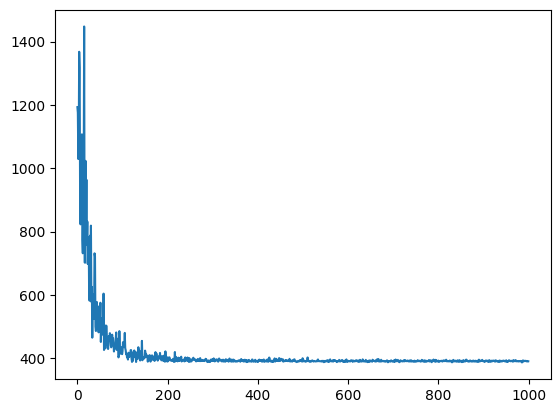

In [5]:
pyro.clear_param_store
new_guide = run_svi_inference(
    new_model, n_steps=n_steps, lr=0.01, verbose=True, **new_data
)

#TODO test performance on model subjected to this!
# TODO consider making these class transformations


In [6]:
predictive = Predictive(
    new_model, guide=new_guide, num_samples=num_samples, parallel=True
)

samples = predictive(**new_data)

In [31]:
print(samples['weights_categorical_zone_id_past_reform'].squeeze().shape)

print(indexing_dictionaries[('zone_id', 'past_reform')])

torch.Size([1000, 8])
{(0, 0): 0, (0, 1): 1, (1, 0): 2, (1, 1): 3, (2, 0): 4, (2, 1): 5, (3, 0): 6, (3, 1): 7}


['grey', 'green', 'grey', 'green', 'grey', 'green', 'grey', 'green']
dict_keys([(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)])
torch.Size([1000, 2])


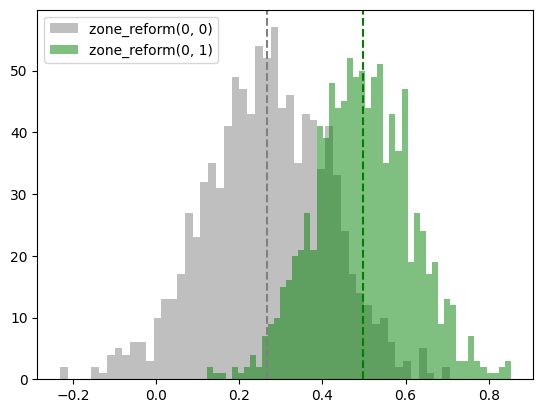

torch.Size([1000, 2])


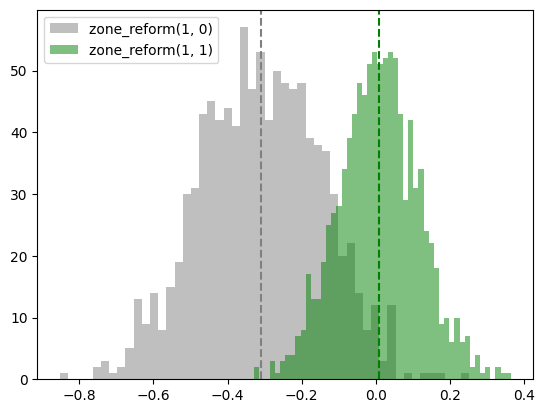

torch.Size([1000, 2])


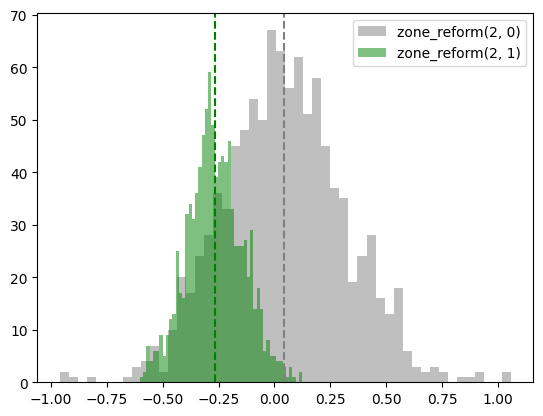

torch.Size([1000, 2])


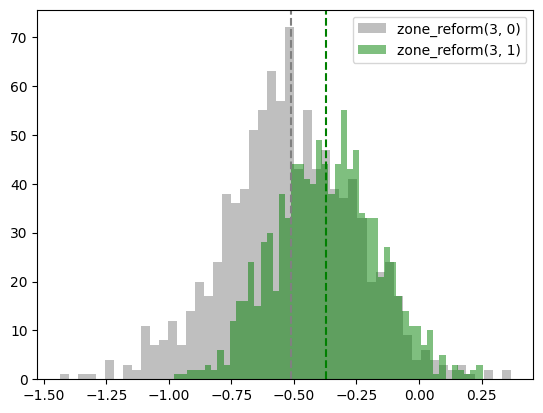

In [47]:
def plot_samples(samples, key, labels, colors):
    limit_samples = samples[key].squeeze()
    
    for i in range(0,len(labels),2):
        
        data = limit_samples[:, i:i+2]

        print(data.shape)
        plt.hist(data[:,0], bins=50, alpha=0.5, label=labels[i], color = colors[i])
        plt.axvline(data[:,0].mean(), linestyle="--", color = colors[i])  
        plt.hist(data[:,1], bins=50, alpha=0.5, label=labels[i+1], color = colors[i+1])
        plt.axvline(data[:,1].mean(), linestyle="--", color = colors[i+1])
        plt.legend()
        plt.show()

samples['weights_categorical_zone_id_past_reform'].shape

labels = [f"zone_reform{key}" for key in indexing_dictionaries[('zone_id', 'past_reform')].keys()]

# colors by whether the second element in the key is 1 or 0
colors = ['grey' if key[1] == 0 else 'green' for key in indexing_dictionaries[('zone_id', 'past_reform')].keys()]
print(colors)

print(indexing_dictionaries[('zone_id', 'past_reform')].keys())


plot_samples(samples, 'weights_categorical_zone_id_past_reform', labels, colors)

In [6]:
#TODO potential path, if so, debug

def add_categorical_interactions_to_class(original_class: Type,
                interaction_tuples: List[Tuple[str, ...]], 
                kwarg_names: Optional[Dict[str, List[str]]] = None):
    
#TODO allow for original class kwargs passing


    class InteractionClass(original_class):
        def __init__(self, **data: Dict):

            self.new_data = replace_categorical_with_combos(data, interaction_tuples, kwarg_names)
    
            super().__init__(**new_data)
          
        def forward(self, **data):

            self.new_data = replace_categorical_with_combos(data, interaction_tuples, kwarg_names)

        
            return super().forward(**self.new_data)
        
    return InteractionClass


In [7]:
print(data['categorical'].keys())

LinearWithInteractions = add_categorical_interactions_to_class(SimpleLinear, [("zone_id", "past_reform")], kwarg_names)

new_model = LinearWithInteractions(**data)

print(new_model.new_data['categorical'].keys())


dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month'])
dict_keys(['zone_id_past_reform'])


[iteration 0001] loss: 389.1428
[iteration 0050] loss: 389.4945
[iteration 0100] loss: 389.8280
[iteration 0150] loss: 392.2303
[iteration 0200] loss: 390.4484
[iteration 0250] loss: 391.5526
[iteration 0300] loss: 389.5795
[iteration 0350] loss: 390.2415
[iteration 0400] loss: 391.2827
[iteration 0450] loss: 389.8821
[iteration 0500] loss: 391.0512
[iteration 0550] loss: 391.2270
[iteration 0600] loss: 392.8027
[iteration 0650] loss: 388.8764
[iteration 0700] loss: 389.2711
[iteration 0750] loss: 390.5319
[iteration 0800] loss: 390.5163
[iteration 0850] loss: 390.2690
[iteration 0900] loss: 390.3005
[iteration 0950] loss: 389.0497
[iteration 1000] loss: 389.7089


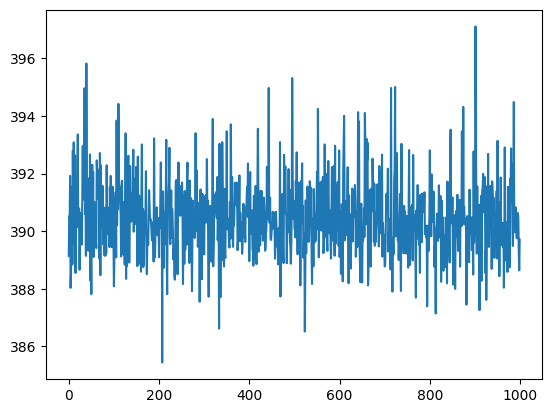

In [8]:
guide = run_svi_inference(
    new_model, n_steps=n_steps, lr=0.01, verbose=True, **data
)

In [5]:
def instantiate_model(model_class: Type, data: Dict, **kwargs: Dict):
    model = model_class(**data, **kwargs)

    return model

model = instantiate_model(SimpleLinear, new_data)

In [6]:

@contextlib.contextmanager
def CategoricalInteraction(data: Dict, 
                           interaction_pair: Tuple[str,str], 
                           kwarg_names: Optional[Dict[str, List[str]]]= None):
    
    #assert that the interaction pair is in the data
    assert interaction_pair[0] in data['categorical'].keys()
    assert interaction_pair[1] in data['categorical'].keys()

    if kwarg_names:
        print(":here")
        data = select_from_data(data, kwarg_names)

    stacked_tensor = torch.stack((data['categorical'][interaction_pair[0]],
                                data['categorical'][interaction_pair[1]]), dim=-1)
    
    unique_pairs, inverse_indices = torch.unique(stacked_tensor, 
                                                 return_inverse=True, dim=0)
    
    unique_combined_tensor = inverse_indices.reshape(
        data['categorical'][interaction_pair[0]].shape)
    
    data['categorical'][
        f"{interaction_pair[0]}_{interaction_pair[1]}"] = unique_combined_tensor

    for key in interaction_pair:
        data['categorical'].pop(key, None)

    yield (model, data)
  